# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import bbknn 

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Import the FBM 

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20201007.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 103228 × 33712 
    obs: 'cell.labels', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'processing.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sort.ids', 'april_cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'nk_meta', 'mito.threshold'
    var: 'gene_ids-1', 'feature_types-1'
    obsm: 'X_orig_pca', 'X_pca', 'X_umap'

In [6]:
cell_numbers = adata.obs.groupby(["orig.ident"]).apply(len)
cell_numbers

orig.ident
F21         3142
F29         8161
F30        10412
F38         3115
F41         7907
F45         6602
F50        15762
F51        28801
SB19PCW    19326
dtype: int64

In [7]:
adata = adata[adata.obs['orig.ident'].isin(['F38', 'F45'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(["orig.ident"]).apply(len)
cell_numbers

orig.ident
F38    3115
F45    6602
dtype: int64

In [9]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell                   76
CD8 T cell                   32
CD14 monocyte               939
CD56 bright NK               54
CMP                          89
DC1                           4
DC2                          67
DC3                         102
DC precursor                 24
ELP                         220
GMP                         242
HSC                          15
ILC precursor                27
LMPP                          6
MEMP                          1
MEP                          26
MK                          144
MOP                         631
MPP myeloid                  16
NK T cell                    20
NK progenitor                 4
Treg                         10
adipo-CAR                     9
arteriolar fibroblast        20
basophil                     17
chondrocyte                   6
early MK                    273
early erythroid             452
early osteoblast             21
endosteal fibroblast         12
eo/baso/mast precursor      

In [10]:
from scipy import sparse
array_vals = adata.X
adata.X = sparse.csr_matrix(adata.X)
adata.raw = adata
adata.X = array_vals

In [11]:
adata.obs["dataset"] = "FBM"

In [12]:
fbm = adata

# Import the DS FBM 

In [13]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/fbm_ds_cite_seq/data/fbm_ds_citeseq_plus_scrna_forMS_20210119.h5ad")

In [14]:
adata

AnnData object with n_obs × n_vars = 16743 × 33694 
    obs: '__is_in_cluster__', 'age', 'auto_prd', 'batch', 'cell.labels', 'cell.labels_20200713', 'is_doublet', 'lanes', 'leiden', 'lr_pred', 'mad_prd', 'nGene', 'nUMI', 'n_genes', 'orig.ident', 'percent.mito', 'sequencing.type', 'sex', 'souporcell_assignment', 'souporcell_doublet'
    var: 'gene_ids-0', 'gene_ids-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_orig_pca', 'X_pca', 'X_umap'

In [15]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD8 T cell                 181
CD14 monocyte              320
CD56 bright NK              79
CMP                         50
DC1                         45
DC2                        228
DC3                        108
HSC                        105
ILC precursor               13
MEMP                       130
MK                          83
MOP                        422
MSC                         53
Treg                         8
chondrocyte                  4
early B cell                42
early MK                    34
early erythroid           1348
endothelium                111
eo/baso/mast precursor      53
eosinophil                  63
late erythroid            6336
macrophage                 113
mast cell                   39
mast cell                   27
mature B cell               31
mature NK                  147
mid erythroid             5230
myelocyte                  243
neutrophil                 273
osteoblast                 

In [16]:
from scipy import sparse
array_vals = adata.X
adata.X = sparse.csr_matrix(adata.X)
adata.raw = adata
adata.X = array_vals

In [17]:
adata.obs["dataset"] = "DS"

In [18]:
ds = adata

# Combine the datasets 

In [19]:
merged = fbm.concatenate(ds, index_unique=None, join='outer', batch_key="dataset", batch_categories=["fbm", "ds"])

In [20]:
merged.shape

(26460, 33712)

In [21]:
merged.obs["dataset_cell.labels"] = merged.obs["dataset"].astype(str) + '_' + merged.obs["cell.labels"].astype(str)

In [22]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].replace(["mast cell "], ["mast cell"])

In [23]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          4
CD14 monocyte              320
CD56 bright NK              79
CD8 T cell                 181
CMP                         50
DC1                         45
DC2                        228
DC3                        108
HSC                        105
ILC precursor               13
MEMP                       130
MK                          83
MOP                        422
MSC                         53
Treg                         8
chondrocyte                  4
early B cell                42
early MK                    34
early erythroid           1348
endothelium                111
eo/baso/mast precursor      53
eosinophil                  63
late erythroid            6336
macrophage                 113
mast cell                   66
mature B cell               31
mature NK                  147
mid erythroid             5230
myelocyte                  243
neutrophil                 273
osteoblast                  11
osteoclast                 

In [24]:
cell_numbers = merged.obs.groupby(["dataset_cell.labels"]).apply(len)
cell_numbers

dataset_cell.labels
ds_CAR                            4
ds_CD14 monocyte                320
ds_CD56 bright NK                79
ds_CD8 T cell                   181
ds_CMP                           50
ds_DC1                           45
ds_DC2                          228
ds_DC3                          108
ds_HSC                          105
ds_ILC precursor                 13
ds_MEMP                         130
ds_MK                            83
ds_MOP                          422
ds_MSC                           53
ds_Treg                           8
ds_chondrocyte                    4
ds_early B cell                  42
ds_early MK                      34
ds_early erythroid             1348
ds_endothelium                  111
ds_eo/baso/mast precursor        53
ds_eosinophil                    63
ds_late erythroid              6336
ds_macrophage                   113
ds_mast cell                     39
ds_mast cell                     27
ds_mature B cell                 31
ds_matur

In [25]:
adata = merged

In [26]:
adata_raw=adata

# Add in the broad annotation

In [27]:
# ask laura to add in broad categories for the total dataset
#pd.DataFrame(adata.obs["cell.labels"].unique()).to_csv('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/combined_cell_types_broad_map.csv')

# load in the completed cell.labels to broad_cell.labels mapping as csv and into metadata
broad_annotation = pd.read_csv('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/combined_cell_types_broad_map_LJ.csv', index_col=False)

In [28]:
# convert the clusters column to a string (so that it can be input into the replace function, which acts on strings)
broad_annotation["cell.labels"] = broad_annotation["cell.labels"].apply(str)
# make a temp metadata column for new cell labels from the leiden clusters
adata.obs["broad_cell.labels"] = adata.obs["cell.labels"]

In [29]:
# save the clusters/categories columns as named lists 
clusters = broad_annotation["cell.labels"].tolist()
categories = broad_annotation["broad_cell.labels"].tolist()
# replace all values in new.cell.labels column matchin clusters values with categories values
adata.obs["broad_cell.labels"] = adata.obs["cell.labels"].replace(clusters, categories)

In [30]:
cell_numbers = adata.obs.groupby(["cell.labels", "broad_cell.labels"]).apply(len)
cell_numbers.to_csv('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/combined_fbm_ds_cell_types_broad_20210119.csv')
cell_numbers

cell.labels              broad_cell.labels
CAR                      stroma                  4
CD14 monocyte            monocyte             1259
CD4 T cell               T_NK                   76
CD56 bright NK           T_NK                  133
CD8 T cell               T_NK                  213
CMP                      HSC_MPP               139
DC precursor             DC                     24
DC1                      DC                     49
DC2                      DC                    295
DC3                      DC                    210
ELP                      HSC_MPP               220
GMP                      HSC_MPP               242
HSC                      HSC_MPP               120
ILC precursor            T_NK                   40
LMPP                     HSC_MPP                 6
MEMP                     HSC_MPP               131
MEP                      HSC_MPP                26
MK                       MK                    227
MOP                      monocyte      

In [31]:
cell_numbers = adata.obs.groupby(["dataset", "broad_cell.labels"]).apply(len)
cell_numbers.to_csv('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/resources_for_pipelines/combined_fbm_ds_dataset_broad_20210119.csv')
cell_numbers

dataset  broad_cell.labels
fbm      B_lineage             1696
         DC                     261
         HSC_MPP                657
         MK                     417
         T_NK                   238
         eo/baso/mast           253
         erythroid             1277
         monocyte              2588
         neutrophil             782
         stroma                1548
ds       B_lineage              188
         DC                     505
         HSC_MPP                338
         MK                     117
         T_NK                   439
         eo/baso/mast           129
         erythroid            12914
         monocyte              1137
         neutrophil             623
         stroma                 353
dtype: int64

# Pre-process the total dataset

In [32]:
# normalise count data 
sc.pp.normalize_total(adata)

In [33]:
# log the count data 
sc.pp.log1p(adata)

In [34]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [35]:
# scale the data 
sc.pp.scale(adata, max_value=10)
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [36]:
# run pca
sc.tl.pca(adata, n_comps=50)

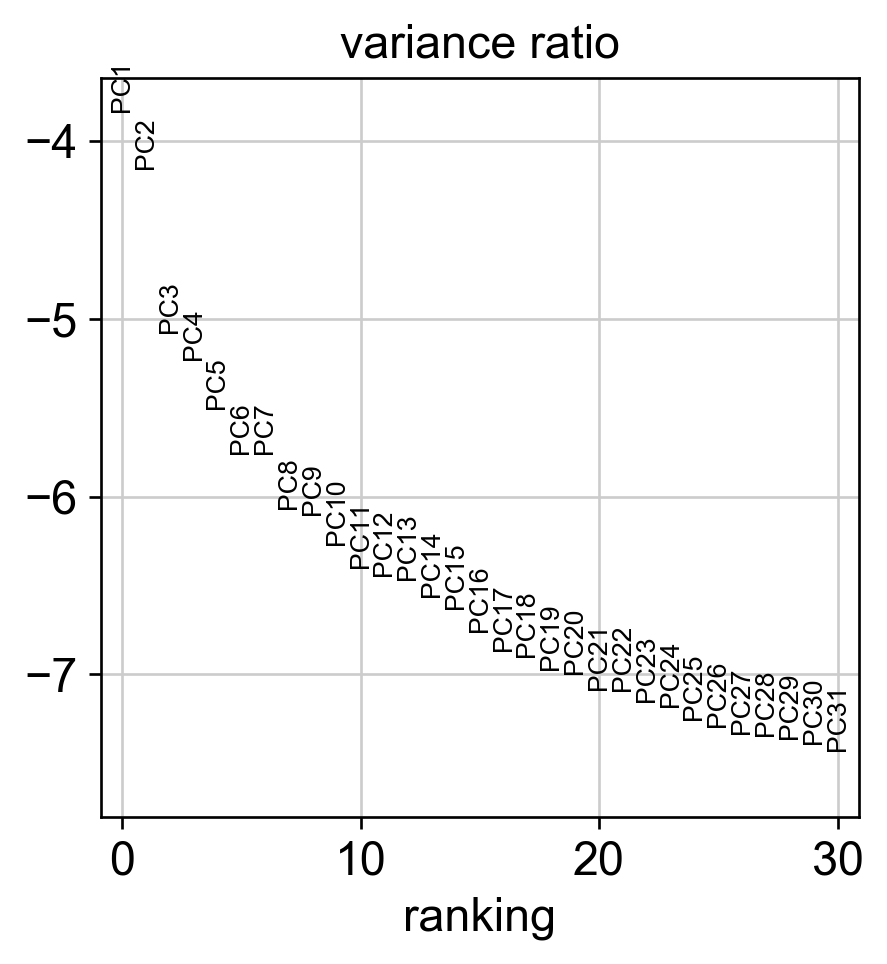

In [37]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [38]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=30) 

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostic

In [39]:
# run umap
sc.tl.umap(adata) 

In [40]:
adata.obs["broad_cell.labels"] = adata.obs["broad_cell.labels"].astype('category')
adata.obs["broad_cell.labels"].cat.categories

Index(['B_lineage', 'DC', 'HSC_MPP', 'MK', 'T_NK', 'eo/baso/mast', 'erythroid', 'monocyte', 'neutrophil', 'stroma'], dtype='object')

In [41]:
new_colors = np.empty(len(adata.obs["broad_cell.labels"].cat.categories), dtype=object) 

new_colors[[0]] = '#d1db94' # B lineage
new_colors[[1]] = '#4d78bc' # DC
new_colors[[2]] = '#f9f06c' # HSC/MPP
new_colors[[3]] = '#8e88a8' # MK
new_colors[[4]] = '#d43d6a' # TNK
new_colors[[5]] = '#a9479a' # eo/baso/mast
new_colors[[6]] = '#f59771' # erythroid
new_colors[[7]] = '#86b3e0' # monocyte
new_colors[[8]] = '#f3c3db' # neutrophil
new_colors[[9]] = '#48b9b4' # stroma

adata.uns["broad_cell.labels_colors"] = new_colors

new_colors

array(['#d1db94', '#4d78bc', '#f9f06c', '#8e88a8', '#d43d6a', '#a9479a',
       '#f59771', '#86b3e0', '#f3c3db', '#48b9b4'], dtype=object)

... storing '__is_in_cluster__' as categorical
... storing 'age' as categorical
... storing 'april_cell.labels' as categorical
... storing 'auto_prd' as categorical
... storing 'batch' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_20200718' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'leiden' as categorical
... storing 'lr_pred' as categorical
... storing 'mad_prd' as categorical
... storing 'mito.threshold' as categorical
... storing 'nk_meta' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sequencing.type' as categorical
... s

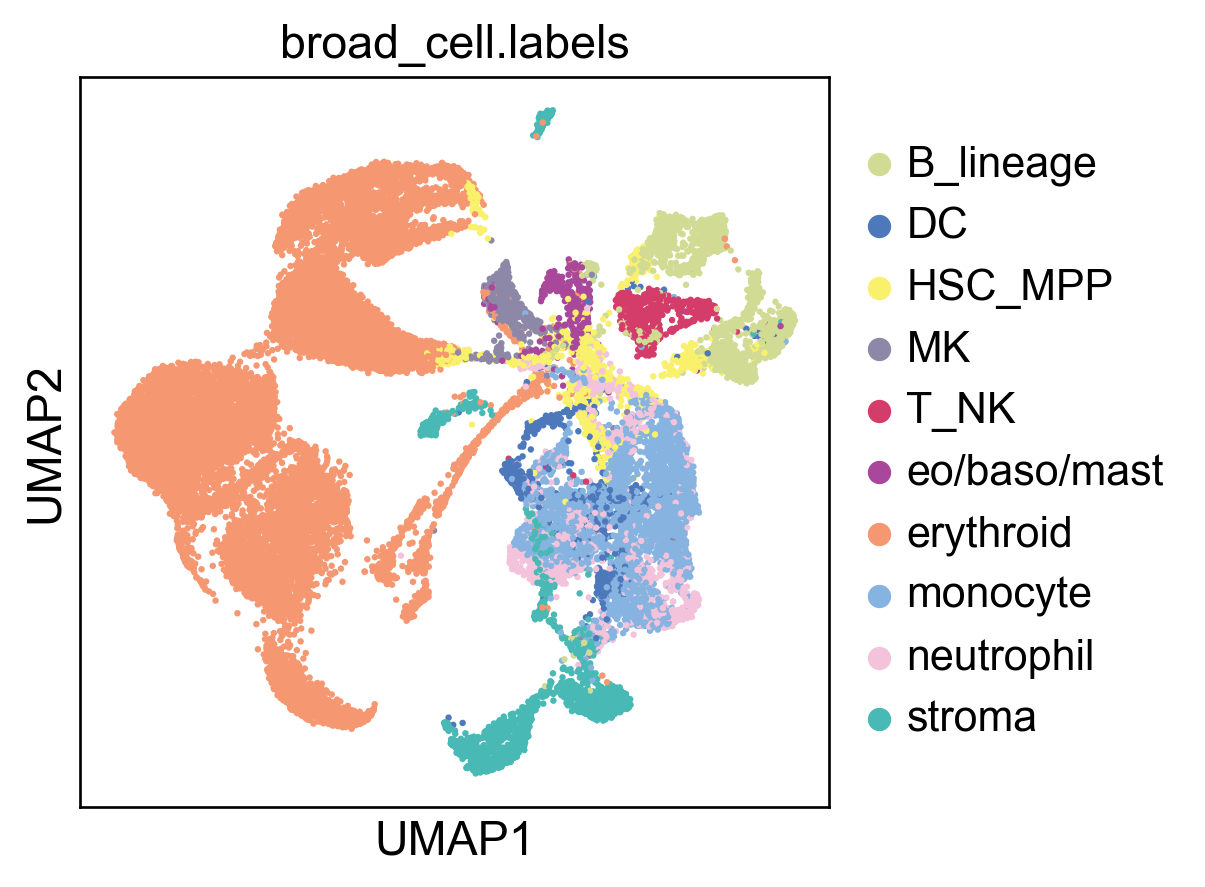

In [42]:
sc.pl.umap(adata, color=['broad_cell.labels'], size=15) 

In [43]:
## UMAP
sc.pl.umap(adata, color='cell.labels', save='_fbm_ds_pre-harmony_20210119_labels_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='cell.labels', save='_fbm_ds_pre-harmony_20210119_labels_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='broad_cell.labels', save='_fbm_ds_pre-harmony_20210119_labels_broad_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='broad_cell.labels', save='_fbm_ds_pre-harmony_20210119_labels_broad_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='sequencing.type', save='_fbm_ds_pre-harmony_20210119_seqtype_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='sequencing.type', save='_fbm_ds_pre-harmony_20210119_seqtype_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='orig.ident', save='_fbm_ds_pre-harmony_20210119_sample_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='orig.ident', save='_fbm_ds_pre-harmony_20210119_sample_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='dataset', save='_fbm_ds_pre-harmony_20210119_dataset_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='dataset', save='_fbm_ds_pre-harmony_20210119_dataset_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

# Run harmony batch correction

In [44]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [45]:
# load up harmony in rpy2
%load_ext rpy2.ipython

In [46]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

R[write to console]: Harmony 7/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write t

In [47]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add UMAP 

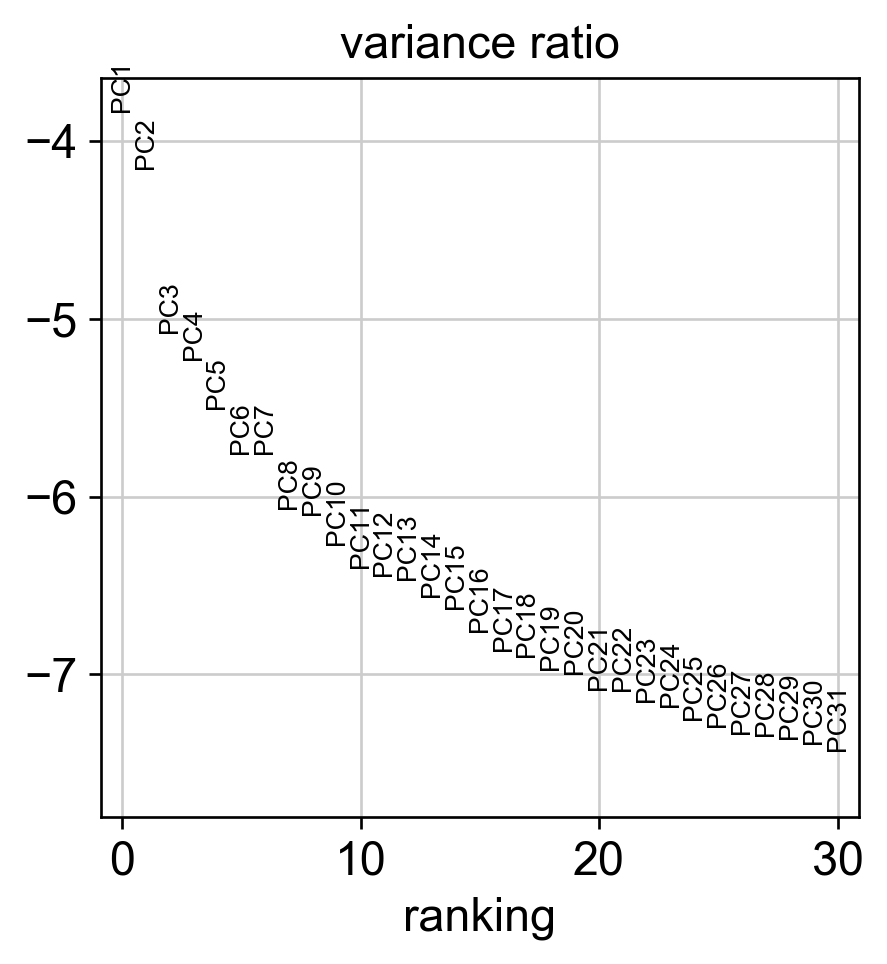

In [48]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [49]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=20) 

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagn

In [50]:
# run umap
sc.tl.umap(adata) 

# Plot UMAP

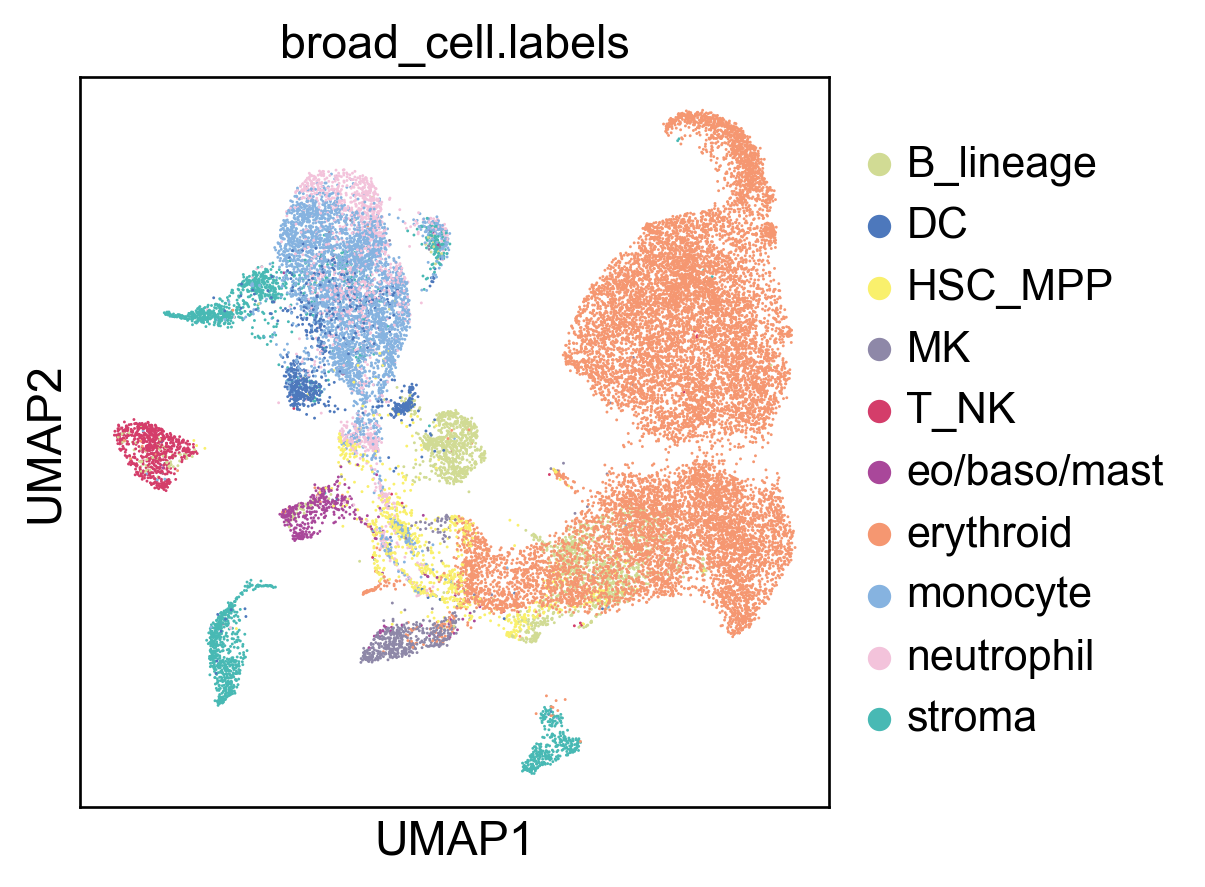

In [51]:
sc.pl.umap(adata, color=['broad_cell.labels'], size=3)

In [52]:
## UMAP
sc.pl.umap(adata, color='cell.labels', save='_fbm_ds_post-harmony_20210119_labels_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='cell.labels', save='_fbm_ds_post-harmony_20210119_labels_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='broad_cell.labels', save='_fbm_ds_post-harmony_20210119_labels_broad_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='broad_cell.labels', save='_fbm_ds_post-harmony_20210119_labels_broad_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='sequencing.type', save='_fbm_ds_post-harmony_20210119_seqtype_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='sequencing.type', save='_fbm_ds_post-harmony_20210119_seqtype_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='orig.ident', save='_fbm_ds_post-harmony_20210119_sample_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='orig.ident', save='_fbm_ds_post-harmony_20210119_sample_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

sc.pl.umap(adata, color='dataset', save='_fbm_ds_post-harmony_20210119_dataset_legoff.pdf', show=False, size=15) 
sc.pl.umap(adata, color='dataset', save='_fbm_ds_post-harmony_20210119_dataset_legon.pdf', show=False, size=15, legend_loc="on data", legend_fontsize=6)

# Save the combined data

In [53]:
adata.X = adata_raw.X
del adata.raw

In [54]:
adata

AnnData object with n_obs × n_vars = 26460 × 33712 
    obs: '__is_in_cluster__', 'age', 'april_cell.labels', 'auto_prd', 'batch', 'cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'dataset', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'leiden', 'lr_pred', 'mad_prd', 'mito.threshold', 'nGene', 'nUMI', 'n_genes', 'nk_meta', 'orig.ident', 'percent.mito', 'processing.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sex', 'sort.ids', 'souporcell_assignment', 'souporcell_doublet', 'dataset_cell.labels', 'broad_cell.labels'
    var: 'gene_ids-1-fbm', 'feature_types-1-fbm', 'gene_ids-0-ds', 'gene_ids-1-ds', 'highly_variable-1-ds', 'means-1-ds', 'dispersions-1-ds', 'dispersions_norm-1-ds', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'broad_cell.labels_colors', 'cell.labels_colors', 'sequencing.type_colors', 'orig.ident_colors', 'data

In [55]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [56]:
adata.X

<26460x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 48881068 stored elements in Compressed Sparse Row format>

In [57]:
adata.raw.X

AttributeError: 'NoneType' object has no attribute 'X'

In [58]:
adata.shape

(26460, 33712)

In [59]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fbm_ds_combined_20210119.h5ad")